Link to Tutorial: https://kwant-project.org/doc/1/tutorial/spin_potential_shape

Extend 2D Electron Gas Hamiltonian by a Rashba spin-orbit coupling and a Zeeman splitting due to an external magnetic field.

$$
H=\frac{-\hbar^2}{2 m}\left(\partial_x^2+\partial_y^2\right)-i \alpha\left(\partial_x \sigma_y-\partial_y \sigma_x\right)+E_{\mathrm{Z}} \sigma_z+V(y)
$$

In [3]:
import tinyarray
import kwant

from matplotlib import pyplot

In [4]:
# define Pauli-matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [10]:
def make_system(a = 1, t = 1.0, W= 10, L=30, alpha = 0.5, e_z = 0.08, L_well = 10):
    # Empty tight binding - hopping integral not defined yet.
    # Start with single square lattice
    lat = kwant.lattice.square(a)
    
    # set up kwant system
    syst = kwant.Builder()


    # define potential profile
    def potential(site, pot):
        (x, y) = site.pos
        if (L - L_well) / 2 < x < (L + L_well) / 2:
            return pot
        else:
            return 0
    
    def onsite(site, pot):
        return 4 * t * sigma_0 + e_z * sigma_z + potential(site, pot)


    syst[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    # hoppings in x-direction
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = \
        -t * sigma_0 + 1j * alpha * sigma_y / 2
    # hoppings in y-directions
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = \
        -t * sigma_0 - 1j * alpha * sigma_x / 2

    # create leads and attach them to the edges of the lattice structure
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, j) for j in range(W))] = 4 * t * sigma_0 + e_z * sigma_z
    # hoppings in x-direction
    lead[kwant.builder.HoppingKind((1, 0), lat, lat)] = \
        -t * sigma_0 + 1j * alpha * sigma_y / 2
    # hoppings in y-directions
    lead[kwant.builder.HoppingKind((0, 1), lat, lat)] = \
        -t * sigma_0 - 1j * alpha * sigma_x / 2

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    return syst

In [24]:
def plot_conductance(syst, welldepths):
    data = []
    energy = 0.2
    for welldepth in welldepths:
        smatrix = kwant.smatrix(syst, energy, params=dict(pot=-welldepth))
        data.append(smatrix.transmission(1, 0))

    pyplot.figure()
    pyplot.plot(welldepths, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()

In [25]:
def main():
    syst = make_system()

    kwant.plot(syst)
    
    # Finalise the tight binding system for transport calculations
    syst = syst.finalized()

    plot_conductance(syst=syst, welldepths= [0.01 * i for i in range(100)])
    



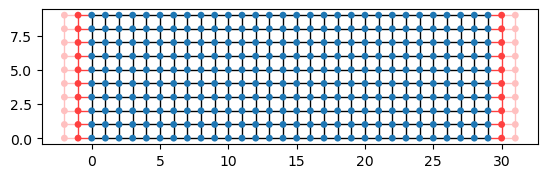

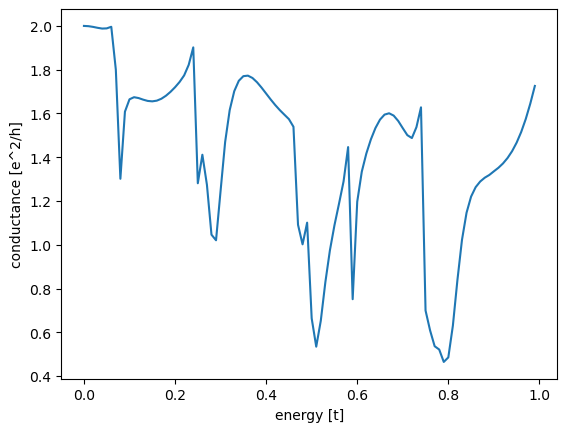

In [26]:
if __name__ == '__main__':
    main()